In [1]:
import pandas as pd

df_meter = pd.read_csv('EV_train.csv')
df_label = pd.read_csv('EV_train_labels.csv')
df_test = pd.read_csv('EV_test.csv')
df_sub = pd.read_csv('sample_submission.csv')

/Anaconda/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
df_meter.head()

,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11655099,0.950,0.826,0.361,0.238,0.342,0.233000,0.351000,0.194000,0.292000,...,0.664,0.783,0.601,0.639,0.417,0.439,0.226,0.190,0.710,0.728
1,11633257,0.353,0.327,0.358,0.292,0.285,0.304000,0.361000,0.342000,0.355000,...,0.536,0.558,0.622,0.634,0.513,0.421,0.273,0.296,0.291,0.289
2,11651552,0.150,0.181,0.150,0.150,0.131,0.125000,0.088000,0.106000,0.094000,...,2.125,0.881,0.481,1.194,0.138,0.119,0.038,0.088,0.056,0.113
3,11636092,2.088,2.075,2.121,2.098,2.046,2.081000,1.847000,0.420000,0.399000,...,0.620,0.487,0.563,0.419,0.379,0.359,0.347,0.325,0.330,0.340
4,11647239,1.416,1.250,1.270,1.258,1.239,1.753105,4.609256,4.619256,4.075151,...,1.596,1.667,1.569,1.664,1.580,1.635,1.568,1.565,1.575,1.571


In [3]:
df_meter.set_index('House ID', inplace=True)
df_label.set_index('House ID', inplace=True)

In [4]:
# Find null values in training data and training label and drop them
list1 = df_meter[pd.isnull(df_meter).any(axis=1)].index.tolist()
df_meter = df_meter.drop(index=list1)
df_label = df_label.drop(index=list1)

In [5]:
df_meter.shape, df_label.shape

((1586, 2880), (1586, 2880))

In [6]:
a = df_meter.columns == df_label.columns
a.all()

True

In [7]:
ev_label = pd.DataFrame(data = df_label.max(axis=1), index = df_label.index)
ev_label.columns = ['label']

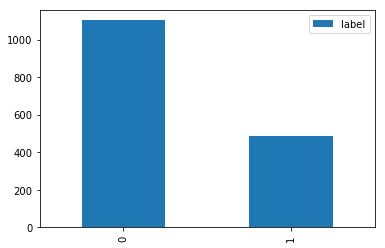

In [8]:
import matplotlib.pyplot as plt
ev_label.label.value_counts().to_frame().plot(kind='bar')
plt.show()

# Unbalanced data

In [9]:
df_train = df_meter

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit 


/Anaconda/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Anaconda/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Anaconda/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Anaconda/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [11]:
# Time series split to prserve the sequential nature of data

tscv = TimeSeriesSplit(n_splits = 3)
my_cv = tscv.split(df_train)

In [12]:
# class weight set to balanced due to unbalanced data

pipe = Pipeline(steps=[('scaler',StandardScaler()),
                      ('clf',svm.SVC(kernel='poly', degree=3,class_weight='balanced'))])

In [13]:
# Scoring was set to compute precision, recall and f1. The model refit was set on f1 score.

param_grid = {'clf__C':[1,10,100,1000],
             'clf__coef0':[0,0.1,1,2],
             }
scoring = {'prc':'precision','rc':'recall','f1':'f1'}

gs = GridSearchCV(estimator = pipe,
                 param_grid=param_grid,
                 scoring=scoring,
                 refit='f1',
                 cv=my_cv)

In [14]:
gs.fit(df_train, ev_label.label)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x115608c50>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__C': [1, 10, 100, 1000], 'clf__coef0': [0, 0.1, 1, 2]},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score='warn',
       scoring={'prc': 'precision', 'rc': 'recall', 'f1': 'f1'}, verbose=0)

In [15]:
#best hyper parameters 

gs.best_params_

{'clf__C': 10, 'clf__coef0': 1}

In [16]:
#best f1 score

gs.best_score_

0.6329898242043711

In [17]:
f1_list = gs.cv_results_['mean_test_f1']
rc_list = gs.cv_results_['mean_test_rc']
prc_list = gs.cv_results_['mean_test_prc']
result_data=list(zip(f1_list,rc_list,prc_list))
result_frame = pd.DataFrame(result_data, columns=['F1','Recall','Precision'])

In [18]:
result_frame

,F1,Recall,Precision
0,0.467017,0.976360,0.308173
1,0.466920,0.972993,0.308481
2,0.616614,0.505333,0.794731
3,0.624908,0.504297,0.826427
4,0.468956,0.976360,0.309916
5,0.568123,0.636246,0.515286
6,0.632990,0.510678,0.835763
7,0.625557,0.510678,0.813330
8,0.369152,0.246168,0.766275
9,0.592367,0.453604,0.862602
